## Generamos el modelo de ML y lo grabamos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import sys
import os


# Agregar el directorio 'src/notebooks' al sys.path
module_path = os.path.abspath(os.path.join('..', 'utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importar las funciones
import funtions_import_merge as preprocess

import importlib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import pickle

In [3]:
# Recargamos el módulo de funciones para evitar errores en Jupyter notebook
importlib.reload(preprocess)

<module 'funtions_import_merge' from 'c:\\Users\\josea\\github\\S2_ML_LAI_Estimation\\src\\utils\\funtions_import_merge.py'>

In [4]:
file_name_sat = 'S2_SR_USA_2017_2024_SCL.csv'
file_name_insitu = 'NEON_LAI_USA_2017_2024.csv'

### 1. Datos de satelite

Cargamos el dataset de adquisiciones de satelite

In [5]:
df_sat = preprocess.satellite_import(file_name_sat)
df_sat.head(5)

,id,longitude,latitude,time,B1,B2,B3,B4,B5,B6,...,B8,B8A,B9,B11,B12,SCL,QA10,QA20,QA60,Site_sat
23,20190128T154519_20190128T154758_T19TCJ,-71.287337,44.063892,2019-01-28 15:50:57.000,447.0,0.0543,0.0520,0.0584,0.0665,0.1536,...,0.2460,0.2054,2135.0,0.0793,0.0550,4.0,0.0,0.0,0,Bartlett Experimental Forest
24,20190128T154519_20190128T154758_T18TYP,-71.287337,44.063892,2019-01-28 15:51:01.000,240.0,0.0251,0.0346,0.0358,0.0649,0.1531,...,0.2365,0.2108,2132.0,0.0815,0.0570,4.0,0.0,0.0,0,Bartlett Experimental Forest
33,20190222T154241_20190222T154730_T19TCJ,-71.287337,44.063892,2019-02-22 15:50:52.000,592.0,0.0642,0.0854,0.0816,0.0890,0.1784,...,0.2199,0.2268,2616.0,0.1014,0.0616,4.0,0.0,0.0,0,Bartlett Experimental Forest
34,20190222T154241_20190222T154730_T18TYP,-71.287337,44.063892,2019-02-22 15:50:56.000,457.0,0.0438,0.0541,0.0619,0.0842,0.1787,...,0.1845,0.2290,2654.0,0.1034,0.0623,4.0,0.0,0.0,0,Bartlett Experimental Forest
63,20190508T153819_20190508T154933_T19TCJ,-71.287337,44.063892,2019-05-08 15:51:05.057,294.0,0.0388,0.0560,0.0564,0.0942,0.1683,...,0.2432,0.2120,2289.0,0.1615,0.0985,4.0,0.0,0.0,0,Bartlett Experimental Forest


### 2. Datos de campo

Cargamos el dataset de medidas insitu.

In [6]:
df_insitu = preprocess.insitu_import(file_name_insitu)
df_insitu.head(5)

,GBOV_ID,Site,GROUND_DATA_PI,GROUND_DATA_PIs_Email,GBOV_Email,Network,Elevation,IGBP_class,Lat_IS,Lon_IS,...,clumping_Miller_down,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,Warren_up_flag,Warren_down_flag,LAI_Warren,LAI_Warren_err
0,GBOV_RM7_1223,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.75,0.80,0.029,0.04,0.11,0.19,0.0,0.0,3.89,0.19
2,GBOV_RM7_1235,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.76,0.74,0.033,0.05,0.08,0.17,0.0,0.0,5.37,0.41
6,GBOV_RM7_1211,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.74,0.79,0.029,0.05,0.05,0.09,0.0,0.0,5.95,0.29
8,GBOV_RM7_1253,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.77,0.83,0.030,0.05,0.08,0.14,0.0,0.0,5.47,0.30
10,GBOV_RM7_1247,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.71,0.72,0.029,0.06,0.10,0.22,0.0,0.0,4.79,0.44


### 3. Combinación de los datasets

**Merge de data sets**. Para cada site identificamos las medidas in_situ mas cercanas a la fecha de adquisicion del satélite

In [7]:
df_cross = preprocess.merge_datasets(df_sat,df_insitu)
df_cross.head(5)

,id,longitude,latitude,time,B1,B2,B3,B4,B5,B6,...,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,Warren_up_flag,Warren_down_flag,LAI_Warren,LAI_Warren_err,delta,date_sat,date_insitu
0,20190607T153819_20190607T154303_T18TYN,-72.171458,42.537834,2019-06-07 15:51:23.000,166.0,0.0198,0.0532,0.0169,0.0982,0.3507,...,0.04,0.09,0.15,0.0,0.0,4.030,0.170,3 days 10:17:23,2019-06-07,2019-06-04
1,20190627T153819_20190627T154123_T18TYN,-72.171458,42.537834,2019-06-27 15:51:23.000,233.0,0.0236,0.0405,0.0193,0.0782,0.3244,...,0.04,0.10,0.19,0.0,0.0,4.820,0.220,4 days 13:44:37,2019-06-27,2019-07-02
2,20190712T153911_20190712T154425_T18TYN,-72.171458,42.537834,2019-07-12 15:51:20.431,288.0,0.0197,0.0203,0.0126,0.0247,0.0888,...,0.04,0.11,0.18,0.0,0.0,3.871,0.195,3 days 13:53:39.569000,2019-07-12,2019-07-16
3,20190801T153911_20190801T154113_T18TYN,-72.171458,42.537834,2019-08-01 15:51:19.875,228.0,0.0176,0.0422,0.0188,0.0757,0.3112,...,0.05,0.08,0.15,0.0,0.0,3.790,0.210,2 days 09:45:19.875000,2019-08-01,2019-07-30
4,20190826T153819_20190826T154455_T18TYN,-72.171458,42.537834,2019-08-26 15:51:19.743,174.0,0.0204,0.0405,0.0182,0.0711,0.2746,...,0.05,0.06,0.09,0.0,0.0,4.281,0.219,0 days 14:23:40.257000,2019-08-26,2019-08-27


### Definimos X_train y y_train

Elegimos fechas del dataset.  
Nos quedamos con los datos del 2017 al 2022. Reservamos los del 2023 para test final.

In [8]:
train_set = df_cross[pd.to_datetime(df_cross['date_insitu']) < pd.to_datetime('2023-01-01')].copy()

Definimos X_train & y_train

In [9]:
X_train = train_set.drop('LAI_Warren', axis=1)
y_train = train_set['LAI_Warren']

### Pipelines y entrenamiento de modelo

Eliminamos columnas innecesarias

In [10]:
columns_to_exclude = ['id', 'longitude', 'latitude', 'time', 'B1', 'B9', 'SCL', 'QA10', 'QA20',
       'QA60', 'Site_sat', 'GBOV_ID', 'Site', 'GROUND_DATA_PI',
       'GROUND_DATA_PIs_Email', 'GBOV_Email', 'Network', 'Elevation',
       'IGBP_class', 'Lat_IS', 'Lon_IS', 'TIME_IS', 'Version', 'up_flag',
       'down_flag', 'LAI_Miller_up', 'LAI_Warren_up', 'LAIe_Miller_up',
       'LAIe_Warren_up', 'LAI_Miller_down', 'LAI_Warren_down',
       'LAIe_Miller_down', 'LAIe_Warren_down', 'LAI_Miller_up_err',
       'LAI_Warren_up_err', 'LAIe_Miller_up_err', 'LAIe_Warren_up_err',
       'clumping_Miller_up', 'clumping_Warren_up', 'LAI_Miller_down_err',
       'LAI_Warren_down_err', 'LAIe_Miller_down_err', 'LAIe_Warren_down_err',
       'clumping_Miller_down', 'clumping_Warren_down',
       'clumping_Miller_up_err', 'clumping_Warren_up_err',
       'clumping_Miller_down_err', 'clumping_Warren_down_err',
       'Warren_up_flag', 'Warren_down_flag', 'LAI_Warren_err',
       'delta', 'date_sat', 'date_insitu']


In [11]:
pipeline = Pipeline([
    ('pipe_exclude_columns', ColumnTransformer([("excluye","drop", columns_to_exclude)], remainder = "passthrough")),
    ("SScaler", StandardScaler()),
    ("Modelo", LinearRegression())
])

pipeline.fit(X_train, y_train)

c:\Users\josea\github\S2_ML_LAI_Estimation\venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipe_exclude_columns',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('excluye', 'drop',
                                                  ['id', 'longitude',
                                                   'latitude', 'time', 'B1',
                                                   'B9', 'SCL', 'QA10', 'QA20',
                                                   'QA60', 'Site_sat',
                                                   'GBOV_ID', 'Site',
                                                   'GROUND_DATA_PI',
                                                   'GROUND_DATA_PIs_Email',
                                                   'GBOV_Email', 'Network',
                                                   'Elevation', 'IGBP_class',
                                                   'Lat_IS', 'Lon_IS',
                                                   'TIME_IS', 'Version',
                                                   'up_flag', 'down_flag',
                                                   'LAI_Miller_up',
                                                   'LAI_Warren_up',
                                                   'LAIe_Miller_up',
                                                   'LAIe_Warren_up',
                                                   'LAI_Miller_down', ...])])),
                ('SScaler', StandardScaler()), ('Modelo', LinearRegression())])

In [12]:
pipeline

Pipeline(steps=[('pipe_exclude_columns',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('excluye', 'drop',
                                                  ['id', 'longitude',
                                                   'latitude', 'time', 'B1',
                                                   'B9', 'SCL', 'QA10', 'QA20',
                                                   'QA60', 'Site_sat',
                                                   'GBOV_ID', 'Site',
                                                   'GROUND_DATA_PI',
                                                   'GROUND_DATA_PIs_Email',
                                                   'GBOV_Email', 'Network',
                                                   'Elevation', 'IGBP_class',
                                                   'Lat_IS', 'Lon_IS',
                                                   'TIME_IS', 'Version',
                                                   'up_flag', 'down_flag',
                                                   'LAI_Miller_up',
                                                   'LAI_Warren_up',
                                                   'LAIe_Miller_up',
                                                   'LAIe_Warren_up',
                                                   'LAI_Miller_down', ...])])),
                ('SScaler', StandardScaler()), ('Modelo', LinearRegression())])

### Prueba modelo contra train

In [13]:
y_pred = pipeline.predict(X_train)

In [14]:
argumentos = (y_train, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', pipeline.score(X_train, y_train))

MSE: 1.051332680071579
RMSE: 1.0253451516789744
MAE: 0.8122572179674007
MAPE: 0.698731596220652
R2: 0.7212581796005735


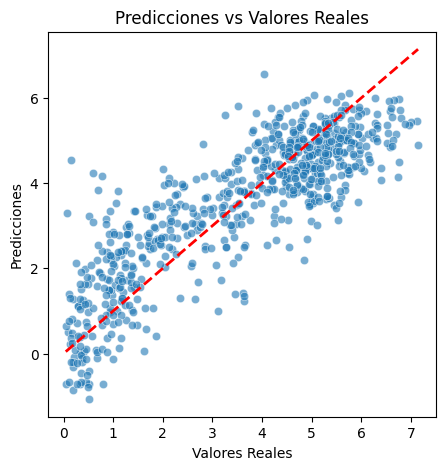

In [15]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

### Grabamos el modelo

In [16]:
# Usando pickle:
with open('../models/modelo_pipeline.pkl', 'wb') as archivo:
    pickle.dump(pipeline, archivo)